In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from sklearn.metrics.pairwise import cosine_similarity
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.sql.types import ArrayType, DoubleType

In [3]:
spark = SparkSession.builder \
    .appName("logs") \
    .getOrCreate()

25/05/24 11:10:42 WARN Utils: Your hostname, toma-Nitro-AN517-52 resolves to a loopback address: 127.0.1.1; using 192.168.88.15 instead (on interface wlp0s20f3)
25/05/24 11:10:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/24 11:10:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/24 11:10:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/05/24 11:10:46 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [4]:
df = spark.read.csv("hdfs://localhost:9000/projet/raw/logs/tokenized_access_logs.csv", header=True, inferSchema=True)

In [7]:
df.filter(col("Date") == "9/1/2017 6:00").show(5, False)

+------------------------------------------+-------------------+-------------+-----+----+----------+-------------+--------------------------------------------------------------------------------------------------------------+
|Product                                   |Category           |Date         |Month|Hour|Department|ip           |url                                                                                                           |
+------------------------------------------+-------------------+-------------+-----+----+----------+-------------+--------------------------------------------------------------------------------------------------------------+
|adidas Brazuca 2017 Official Match Ball   |baseball & softball|9/1/2017 6:00|Sep  |6   |fitness   |37.97.182.65 |/department/fitness/category/baseball%20&%20softball/product/adidas%20Brazuca%202017%20Official%20Match%20Ball|
|The North Face Women's Recon Backpack     |hunting & shooting |9/1/2017 6:00|Sep  |6   |fan sho

In [5]:
# Convertir la colonne Date en timestamp
df = df.withColumn("Date", to_timestamp("Date", "M/d/yyyy H:mm"))

# Extraire l'heure
df = df.withColumn("Hour", hour("Date"))


+----+-----+
|Hour|count|
+----+-----+
|   0| 2227|
|   1| 2224|
|   2| 2222|
|   3| 2216|
|   4| 2288|
|   5| 2321|
|   6|22856|
|   7|23387|
|   8|22942|
|   9|22925|
|  10|24036|
|  11|24801|
|  12|24422|
|  13|23441|
|  14|23055|
|  15|23575|
|  16|23868|
|  17|24544|
|  18|25575|
|  19|28292|
+----+-----+
only showing top 20 rows



<Axes: title={'center': 'Nombre de vues par heure'}, xlabel='Hour'>

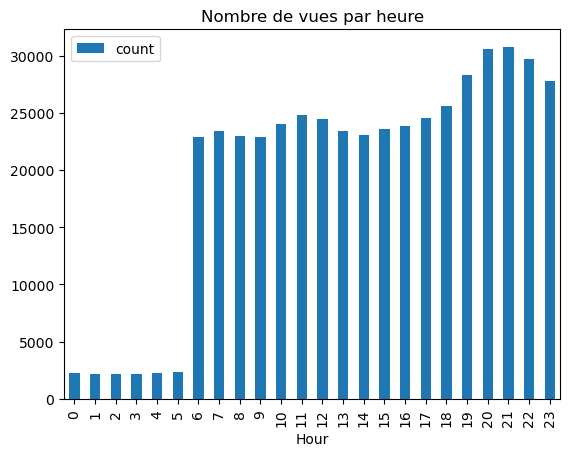

In [6]:
hourly_counts = df.groupBy("Hour").count().orderBy("Hour")
hourly_counts.show()

# Pour visualiser avec matplotlib si besoin
hourly_pd = hourly_counts.toPandas()
hourly_pd.plot(x="Hour", y="count", kind="bar", title="Nombre de vues par heure")


In [7]:
product_views = df.groupBy("Product").count().orderBy(desc("count"))
product_views.show(10)


+--------------------+-----+
|             Product|count|
+--------------------+-----+
|Perfect Fitness P...|27878|
|adidas Kids' RG I...|26200|
|Nike Men's Dri-FI...|25627|
|Nike Men's CJ Eli...|25241|
|O'Brien Men's Neo...|16194|
|Pelican Sunstream...|16186|
|Diamondback Women...|15521|
|Field & Stream Sp...|15178|
|Under Armour Hust...|13752|
|Columbia Men's PF...|13716|
+--------------------+-----+
only showing top 10 rows



In [8]:
ip_views = df.groupBy("ip").count().orderBy(desc("count"))
ip_views.show(10)


+---------------+-----+
|             ip|count|
+---------------+-----+
|  157.21.93.193|  566|
| 138.21.216.113|  557|
| 77.137.114.147|  516|
|   47.102.94.70|  514|
| 83.234.215.133|  514|
| 150.89.112.119|  508|
|  211.122.14.29|  505|
| 99.237.181.177|  502|
|102.172.170.187|  495|
| 69.214.176.127|  493|
+---------------+-----+
only showing top 10 rows



In [9]:
product_hour = df.groupBy("Hour", "Product").count().orderBy("Hour", desc("count"))
product_hour.show(20)


+----+--------------------+-----+
|Hour|             Product|count|
+----+--------------------+-----+
|   0|Perfect Fitness P...|  118|
|   0|adidas Kids' RG I...|  111|
|   0|Nike Men's CJ Eli...|  109|
|   0|Nike Men's Dri-FI...|   91|
|   0|Diamondback Women...|   78|
|   0|O'Brien Men's Neo...|   76|
|   0|Columbia Men's PF...|   72|
|   0|Under Armour Men'...|   68|
|   0|Nike Men's Comfor...|   67|
|   0|Under Armour Hust...|   65|
|   0|Pelican Sunstream...|   64|
|   0|Under Armour Girl...|   64|
|   0|Nike Men's Free 5...|   59|
|   0|Field & Stream Sp...|   58|
|   0|Nike Men's Free T...|   57|
|   0|Stiga Master Seri...|   55|
|   0|Nike Men's Finger...|   53|
|   0|Yakima DoubleDown...|   49|
|   0|The North Face Wo...|   45|
|   0|Ogio Race Golf Shoes|   42|
+----+--------------------+-----+
only showing top 20 rows



In [22]:
spark.stop()

ConnectionRefusedError: [Errno 111] Connection refused